# Итоговый проект первого года обучения <br /> (курс "Профессия Data Science")
## Тема: Агентство недвижимости

**Что необходимо сделать:** разработать сервис для предсказания стоимости домов на основе истории предложений.

## Первичная оценка данных
### Первичная оценка данных и разбиение на валидационный и рабочий наборы данных
*Валидационный набор данных будет использоваться для оценки качество предсказаний сервиса*

### Описание структуры проекта:

* Каталог *app* - файлы сервиса предсказаний цены стоимости домов
* Каталог *model* - анализ, подготовка данных, подбор и обучение модели
* Каталог *shared_libs* - библиотечные функции и данные, совместно используемые как на этапе подготовки модели, так и сервисом

### Каталог *app*:

* Файл *predict_server.py* - сервер сервиса предсказаний стоимости домов
* Файл *test_client.py* - тестовый клиент для проверки работы сервиса (использует валидационный набор данных)

### Каталог *model*:

* Каталог *data* - в данном каталоге находятся файлы с исходными данными для обучения модели
    * Файл *data.csv* - исходный набор данных
    * Файл *data_target_cleared.csv* - данные из которого удалены аномальные выбросы целевого значения и без валидационной набора
    * Файл *data_valid.csv* - валидационный набор (без целевого поля)
    * Файл *data_valid_target.csv* - целевое поле валидационного набора данных (для проверки качество предсказания сервиса)
    * Файл *uscities.csv* - данные по городам США (взят из проекта на сервисе kaggle.com ([источник](https://www.kaggle.com/datasets/sergejnuss/united-states-cities-database)))
* Файл *index.ipynb* - первичная оценка данных, очистка целевого параметра от выбросов, формирование основного и валидационного даборов данных
* Файл *base_line.ipynb* - предобработка базовых признаков, очистка от пропусков, формирование Base Line модели
* Файл *extra_features.ipynb* - создание дополнительных признаков, обучение финальной модели модели
* Файл *validate.ipynb* - тестирование финальной модели модели на валидационной выборке
* Файл *population_features.ipynb* - добавление признаков на основании стат. данных по городам США
* Файл *coord_dicts.ipynb* - формирование кэша с геоданными (города, районы по ZIP коду, адреса объектов недвижимости)
* Файл *model_selection.ipynb* - поиск наиболее подходящей модели предсказания

### Каталог *shared_libs*:

* Каталог *data* - в данном каталоге находятся файлы с данными, используемыми как для обучения модели, так и для работы модели в составе сервиса
    * Каталог *data/models* - каталог, в котором хранятся сериализованные обученные модели
* Файл *data_transform.py* - библиотека с сервисными функциями для работы с данными как на этапе подготоки и обучения модели, так и для работы модели в составе сервиса

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')

In [3]:
import sys, os
sys.path.append(os.path.join(os.path.abspath(''), '..', 'shared_libs'))
import data_transform

In [4]:
df = pd.read_csv('data/data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [5]:
df = df.dropna(subset=['target'], axis=0)

При просмотре значений поля *target* бвли обнаружены значения с постфиксом */mo*.

Судя по всему в эту выборку попали данные не толко о продаже объектов, но по сдаче их в месячную аренду.

Произведем выборку таких значений и графически оценим их распределение.

In [6]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

mo_list = []

def collect_per_month(value):
    global mo_list
    
    if '/mo' in value:
        try:
            result = locale.atof(value.strip("$").strip("/mo"))
            mo_list.append(result)
        except:
            pass
        
df['target'].apply(collect_per_month)

print(min(mo_list), max(mo_list), np.mean(mo_list))

600.0 72500.0 3229.5566750629723


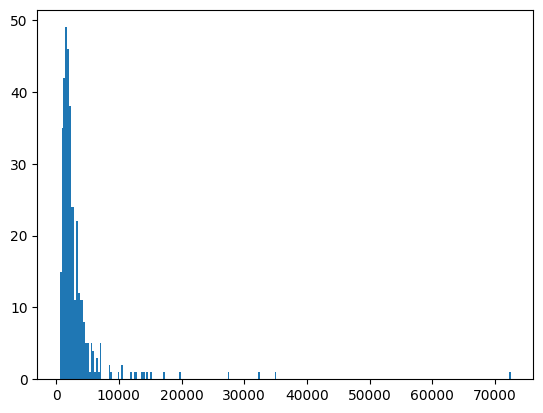

In [7]:
plt.hist(mo_list, bins=250)
plt.show()

Возьмем за верхнюю границу аренды (и соответственно за нижнюю границу валидных данных по продаже) величину в 25000$

In [8]:
df['target'] = df['target'].apply(lambda x: data_transform.target_str_to_float(x))
df = df.dropna(subset=['target'], axis=0)

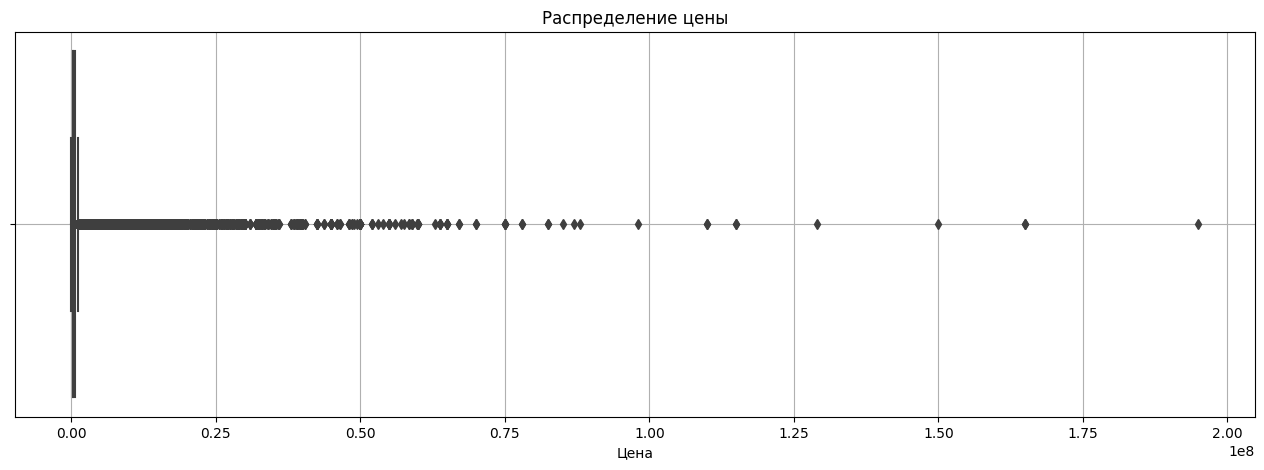

In [14]:
fig = plt.figure(figsize=(16, 5))
boxplot = sns.boxplot(
    data=df,
    x='target',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение цены');
boxplot.set_xlabel('Цена');
boxplot.grid()

Диаграмма распределения цены показывает наличие выбросов в верхей части диапазона цены.

За верхнюю границу допустимых значений цены возьмем значение в 5000000$.

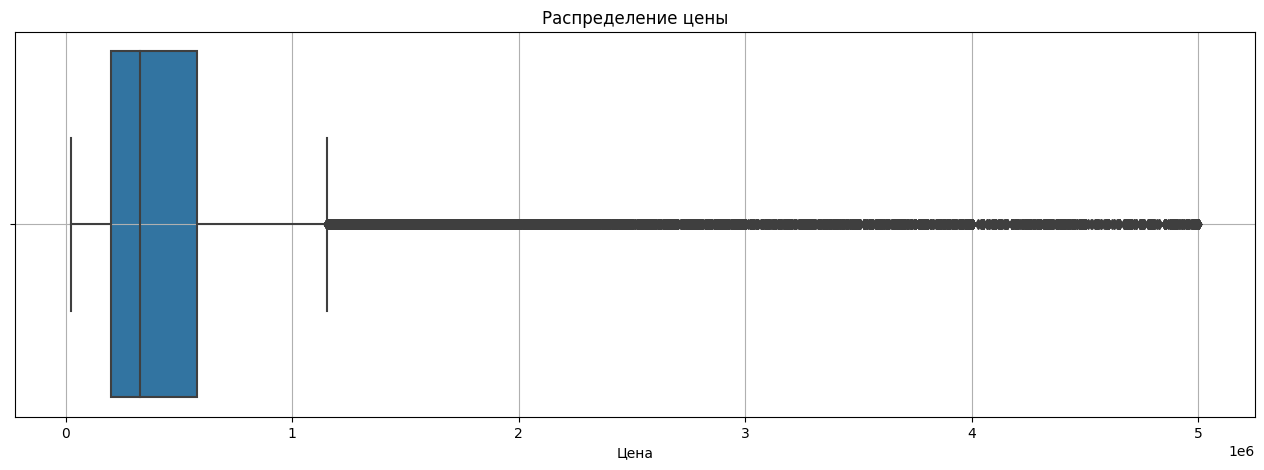

In [15]:
fig = plt.figure(figsize=(16, 5))
boxplot = sns.boxplot(
    data=df[(df['target'] > 25000) & (df['target'] < 5000000)],
    x='target',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение цены');
boxplot.set_xlabel('Цена');
boxplot.grid()

In [10]:
low_bound = 25000
hight_bound = 5000000

data_part_size = df[(df['target'] >= low_bound) & (df['target'] <= hight_bound)].shape[0] / df.shape[0] * 100

df = df[(df['target'] >= low_bound) & (df['target'] <= hight_bound)].copy()

print(data_part_size)

95.3278868091882


Диапазон цены от 25000$ до 5000000$ покрывает 95% исходных данных.

Эту часть данных и принимаем за пригодную для последующе работы.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.005, random_state=42)

Разбиваем данные на основной и валидационый набор.

В дальнейше работе по обучении модели будет использоваться основной набор, валидационный будет использоваться для оценки качества работы сервиса предсказания цены продажи объекта недвижимости.

In [12]:
df = pd.concat([X_train, y_train], axis=1)

In [13]:
df.to_csv('data/data_target_cleared.csv', index=False)

In [14]:
X_valid.to_csv('data/data_valid.csv', index=False)

In [15]:
y_valid.to_csv('data/data_valid_target.csv', index=False)